## Sistema de Recomendacion con Surprise

Se importan las librerias necesarias.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import accuracy

Se cargan las datasets del anterior análisis exploratorio.

In [2]:
data_score = pd.read_csv('score_movies_EDA.csv')
data_plat = pd.read_csv('plataformas_EDA.csv', usecols = [0,2], names = ['movieId', 'name'], skiprows=1)

In [3]:
data_plat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  22998 non-null  object
 1   name     22998 non-null  object
dtypes: object(2)
memory usage: 359.5+ KB


In [4]:
data_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11013823 entries, 0 to 11013822
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   rating   float64
 2   movieId  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 252.1+ MB


In [5]:
data_score.head(3)

,userId,rating,movieId
0,1,1.0,as680
1,1,4.5,ns2186
2,1,5.0,hs2381


Se utiliza la librería Surprise, basada en sklearn que facilita el desarrollo de sistemas de recomendación.

In [159]:
reader = Reader(rating_scale=(1, 5))
# Limitamos el dataset a N_filas
N_filas = 100000 
data_sp = Dataset.load_from_df(data_score[['userId', 'movieId', 'rating']][:N_filas], reader=reader)

Separamos nuestros datos en un set de prueba y otro de entrenamiento del modelo.

In [160]:
trainset, testset = train_test_split(data_sp, test_size=.25)

Luego aplicamos el modelo de Singular Value Decomposition (SVD).

In [161]:
model = SVD()

# Entrenamos el modelo
model.fit(trainset)

# Predecimos con el modelo entrenado

predictions = model.test(testset)

Evaluamos el modelo.

In [162]:
accuracy.rmse(predictions)

RMSE: 0.9628


0.9628357318773172

Optimizamos los hiperparámetros del modelo.

In [144]:
rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data_sp, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9486  0.9498  0.9515  0.9500  0.0012  
Fit time          0.45    0.46    0.37    0.42    0.04    
Test time         0.16    0.74    0.16    0.35    0.28    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9494  0.9488  0.9516  0.9500  0.0012  
Fit time          0.40    0.36    0.36    0.37    0.02    
Test time         0.17    0.35    0.16    0.23    0.09    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9505  0.9498  0.9456  0.9486  0.0021  
Fit time          0.42    0.39    0.37    0.39    0.02    
Test time         0.18    0.20    0.15    0.18    0.02    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9503  0.9

Ploteamos el desempeño del modelo según la cantidad de factores de SVD.

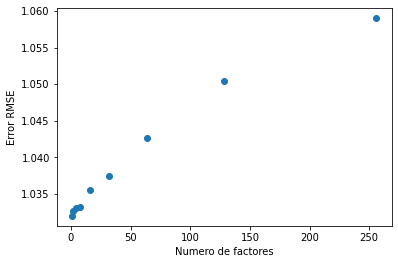

In [42]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [163]:
param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data_sp)

In [164]:
# Observamos performance del mejor modelo
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9443433800365627
{'n_factors': 5, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}


Con los hiperparámetros optimizados, se vuelve a entrenar el modelo.

In [166]:
model_opt = SVD(n_factors=5, n_epochs=20, lr_all=0.002, reg_all=0.002)

model_opt.fit(trainset)
predictions = model_opt.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9448


0.9448331717264494

In [51]:
# Recomendaciones al usuario
rec_usuario = data_plat.iloc[:].copy()

rec_usuario['Estimate_Score'] = rec_usuario['id'].apply(lambda x: model_opt.predict(425, x).est)
rec_usuario = rec_usuario.sort_values('Estimate_Score', ascending=False)

if (len(rec_usuario[(rec_usuario['id'] == 50)])): print('Se recomienda.')
else: print('No se recomienda.')
    

Se recomienda.


In [53]:
model_opt.predict(425, 100)

Prediction(uid=425, iid=100, r_ui=None, est=3.5300533333333335, details={'was_impossible': False})